# 📓 ACCESS-ESM15-temp-rechunk-zarr

**Author:** Thomas Moore  
**Date:** 2025-11-07
**Updated:** YYYY-MM-DD (if applicable)  
**Environment:** `pangeo_csepta` running on `Gadi` ARE  
**Tags:** sandbox, ARD, ACCESS-ESM1.5

---

### 📘 Description

This notebook attempts to bring together all the disperate workplows for this task over the year(s).  Issue: [https://github.com/Thomas-Moore-Creative/Pacific-Tuna-Climate-Response/issues/51](https://github.com/Thomas-Moore-Creative/Pacific-Tuna-Climate-Response/issues/51) and sub-issues

In [1]:
Author = {"name": "Thomas Moore", "affiliation": "CSIRO", "email": "thomas.moore@csiro.au", "orcid": "0000-0003-3930-1946"}

# Software

### ACDtools

In [2]:
!pip install --user -e /g/data/es60/users/thomas_moore/code/ACDtools

Obtaining file:///g/data/es60/users/thomas_moore/code/ACDtools
  Installing build dependencies ... done
  Checking if build backend supports build_editable ... done
  Getting requirements to build editable ... done
  Preparing editable metadata (pyproject.toml) ... done
  Building editable for ACDtools (pyproject.toml) ... done
  Created wheel for ACDtools: filename=acdtools-0.1-0.editable-py3-none-any.whl size=3553 sha256=54db4f4f7d6acf149046e876be69453e2ec495a5a76200351f8e18889f4853b6
  Stored in directory: /scratch/es60/thomas_moore/tmp/pip-ephem-wheel-cache-58_4l44k/wheels/b6/a3/f2/6ce45fbdc116ad50e421d6a11cb060cc796e867501807af446
Successfully built ACDtools
  Attempting uninstall: ACDtools
    Found existing installation: ACDtools 0.1
    Uninstalling ACDtools-0.1:
      Successfully uninstalled ACDtools-0.1


In [3]:
# Enable autoreload in the notebook
%load_ext autoreload
%autoreload 1 
%aimport ACDtools.util
%aimport ACDtools.ard
%aimport ACDtools.ocean
%aimport ACDtools.plot
# Importing from your local package util.py
from ACDtools import util
from ACDtools import ard
from ACDtools import ocean
from ACDtools import plot

In [4]:
import datetime
from pprint import pprint
import intake
import sys
from contextlib import redirect_stdout
import math
import xarray as xr
import logging

## Cluster

In [5]:
client, cluster = util.start_dask_cluster_from_config('zarr_work')

Cluster started with 8 workers.
Dashboard available at: /proxy/8787/status


In [6]:
job_config_path = '/g/data/es60/users/thomas_moore/code/ACDtools/job_config.yaml'
job_config_dict = ACDtools.util.load_config(job_config_path)
job_config_dict

{'paths': {'write_dir': '/scratch/es60/ard/models/ACCESS-ESM15/ARD/',
  'save_coords_dir': '/scratch/es60/ard/models/ACCESS-ESM15/ARD/coords/',
  'log_dir': '/scratch/es60/ard/models/ACCESS-ESM15/ARD/logs/'},
 'dask_cluster': {'netcdf_work': {'n_workers': 'None',
   'threads_per_worker': 1,
   'memory_limit': 'None'},
  'zarr_work': {'n_workers': 'None',
   'threads_per_worker': 'None',
   'memory_limit': 'None'}},
 'catalog_search_query_dict': {'experiment_id': 'historical',
  'source_id': 'ACCESS-ESM1-5',
  'variable_id': 'chl',
  'table_id': 'Omon',
  'version': 'latest'},
 'chunking_key': 'ACCESS_ESM15_3D',
 'chunking': {'ACCESS_ESM15_2D': {'chunks': {'member': 1,
    'time': 220,
    'i': 360,
    'j': 300}},
  'ACCESS_ESM15_3D': {'chunks': {'member': 1,
    'time': 12,
    'lev': -1,
    'i': -1,
    'j': -1}}}}

# logging

In [7]:
logfile = f"{job_config_dict['paths']['log_dir']}log_rechunk_{datetime.datetime.now().strftime('%Y%m%d_%H%M%S')}.txt"
logging.basicConfig(filename=logfile,
                    level=logging.INFO,
                    format='%(asctime)s %(levelname)s:%(message)s',
                    datefmt='%Y-%m-%d %H:%M:%S')

# figure out what base zarr to load and load it

In [8]:
base_zarr_filename = f"ACCESS-ESM1-5.{job_config_dict['catalog_search_query_dict']['experiment_id']}.\
{job_config_dict['catalog_search_query_dict']['variable_id']}.\
base.vYYYYMMDD_HHMMSS.zarr"
base_zarr_filename

'ACCESS-ESM1-5.historical.chl.base.vYYYYMMDD_HHMMSS.zarr'

In [9]:
from pathlib import Path
import re

# regex to match ".vYYYYMMDD_HHMMSS.zarr"
TS_RE = re.compile(r"\.(v\d{8}_\d{6})\.zarr$")

def latest_version_token(dirpath: str | Path, prefix: str) -> str | None:
    """
    Find the latest version token (e.g., 'v20251107_133422')
    in filenames beginning with <prefix> in the given directory.
    """
    dirpath = Path(dirpath)
    candidates = []
    for p in dirpath.iterdir():
        if not p.name.startswith(prefix + "."):
            continue
        m = TS_RE.search(p.name)
        if m:
            token = m.group(1)  # includes the "v"
            # parse for ordering
            dt = datetime.datetime.strptime(token[1:], "%Y%m%d_%H%M%S")
            candidates.append((dt, token))
    if not candidates:
        return None
    candidates.sort()
    return candidates[-1][1]  # return the 'vYYYYMMDD_HHMMSS' token

def fill_latest_in_template(dirpath: str | Path, template: str) -> str:
    """
    Replace the placeholder 'vYYYYMMDD_HHMMSS' in the template with
    the latest found version token (with the 'v' prefix).
    """
    prefix = template.split(".vYYYYMMDD_HHMMSS.zarr")[0]
    token = latest_version_token(dirpath, prefix)
    if token is None:
        raise FileNotFoundError(f"No versioned files for prefix '{prefix}' in {dirpath}")
    return template.replace("vYYYYMMDD_HHMMSS", token)

# ----- usage -----
template = base_zarr_filename
write_dir = job_config_dict['paths']['write_dir'] # your directory

latest_name = fill_latest_in_template(write_dir, template)
print(latest_name)
# e.g. "ACCESS-ESM1-5.historical.chl.base.v20251106_142215.zarr"

ACCESS-ESM1-5.historical.chl.base.v20251106_201202.zarr


In [10]:
base_zarr_2load = write_dir + latest_name
print(base_zarr_2load)

/scratch/es60/ard/models/ACCESS-ESM15/ARD/ACCESS-ESM1-5.historical.chl.base.v20251106_201202.zarr


In [11]:
base_ds = xr.open_zarr(base_zarr_2load,consolidated=True)

# can we rechunk 40 member collections to `for member`?

In [12]:
ds_rc = base_ds.chunk({'member':-1,'time':1,'lev':25})
ds_rc

<xarray.Dataset> Size: 2TB
Dimensions:   (member: 40, time: 1980, lev: 50, j: 300, i: 360, bnds: 2)
Coordinates:
  * i         (i) int32 1kB 0 1 2 3 4 5 6 7 ... 352 353 354 355 356 357 358 359
  * j         (j) int32 1kB 0 1 2 3 4 5 6 7 ... 292 293 294 295 296 297 298 299
  * lev       (lev) float64 400B 5.0 15.0 25.0 ... 5.166e+03 5.499e+03 5.831e+03
    lev_bnds  (lev, bnds) float64 800B dask.array<chunksize=(25, 2), meta=np.ndarray>
  * member    (member) <U9 1kB 'r1i1p1f1' 'r2i1p1f1' ... 'r39i1p1f1' 'r40i1p1f1'
  * time      (time) datetime64[ns] 16kB 1850-01-16T12:00:00 ... 2014-12-16T1...
Dimensions without coordinates: bnds
Data variables:
    chl       (member, time, lev, j, i) float32 2TB dask.array<chunksize=(40, 1, 25, 300, 360), meta=np.ndarray>
Attributes: (12/61)
    Conventions:                      CF-1.7 CMIP-6.2
    NOTE on coordinates:              the multidimensional latitude and longi...
    activity_id:                      CMIP
    branch_method:                    standard
    branch_time_in_child:             0.0
    branch_time_in_parent:            168012.0
    ...                               ...
    table_id:                         Omon
    table_info:                       Creation Date:(30 April 2019) MD5:5bd75...
    title:                            ACCESS-ESM1-5 output prepared for CMIP6
    variable_id:                      chl
    variant_label:                    r21i1p1f1
    version:                          v20200922

In [13]:
ACDtools.util.remove_encoding(ds_rc)

<xarray.Dataset> Size: 2TB
Dimensions:   (member: 40, time: 1980, lev: 50, j: 300, i: 360, bnds: 2)
Coordinates:
  * i         (i) int32 1kB 0 1 2 3 4 5 6 7 ... 352 353 354 355 356 357 358 359
  * j         (j) int32 1kB 0 1 2 3 4 5 6 7 ... 292 293 294 295 296 297 298 299
  * lev       (lev) float64 400B 5.0 15.0 25.0 ... 5.166e+03 5.499e+03 5.831e+03
    lev_bnds  (lev, bnds) float64 800B dask.array<chunksize=(25, 2), meta=np.ndarray>
  * member    (member) <U9 1kB 'r1i1p1f1' 'r2i1p1f1' ... 'r39i1p1f1' 'r40i1p1f1'
  * time      (time) datetime64[ns] 16kB 1850-01-16T12:00:00 ... 2014-12-16T1...
Dimensions without coordinates: bnds
Data variables:
    chl       (member, time, lev, j, i) float32 2TB dask.array<chunksize=(40, 1, 25, 300, 360), meta=np.ndarray>
Attributes: (12/61)
    Conventions:                      CF-1.7 CMIP-6.2
    NOTE on coordinates:              the multidimensional latitude and longi...
    activity_id:                      CMIP
    branch_method:                    standard
    branch_time_in_child:             0.0
    branch_time_in_parent:            168012.0
    ...                               ...
    table_id:                         Omon
    table_info:                       Creation Date:(30 April 2019) MD5:5bd75...
    title:                            ACCESS-ESM1-5 output prepared for CMIP6
    variable_id:                      chl
    variant_label:                    r21i1p1f1
    version:                          v20200922

# set zarr out filename

In [14]:
chunk4member_zarr_name = write_dir+f"ACCESS-ESM1-5.{job_config_dict['catalog_search_query_dict']['experiment_id']}.\
{job_config_dict['catalog_search_query_dict']['variable_id']}.\
chunk4member.v{datetime.datetime.now().strftime('%Y%m%d_%H%M%S')}.zarr"
chunk4member_zarr_name

'/scratch/es60/ard/models/ACCESS-ESM15/ARD/ACCESS-ESM1-5.historical.chl.chunk4member.v20251107_145821.zarr'

In [16]:
%%time
logging.info('chunk4member job started'+datetime.datetime.now().strftime('%Y%m%d_%H%M%S'))
ds_rc.to_zarr(chunk4member_zarr_name,consolidated=True)
logging.info('chunk4member job done'+datetime.datetime.now().strftime('%Y%m%d_%H%M%S'))

CPU times: user 7min 11s, sys: 37.6 s, total: 7min 48s
Wall time: 13min 42s


## read back in

In [17]:
chunk4member = xr.open_zarr(chunk4member_zarr_name,consolidated=True)

In [18]:
chunk4member

<xarray.Dataset> Size: 2TB
Dimensions:   (member: 40, time: 1980, lev: 50, j: 300, i: 360, bnds: 2)
Coordinates:
  * i         (i) int32 1kB 0 1 2 3 4 5 6 7 ... 352 353 354 355 356 357 358 359
  * j         (j) int32 1kB 0 1 2 3 4 5 6 7 ... 292 293 294 295 296 297 298 299
  * lev       (lev) float64 400B 5.0 15.0 25.0 ... 5.166e+03 5.499e+03 5.831e+03
    lev_bnds  (lev, bnds) float64 800B dask.array<chunksize=(25, 2), meta=np.ndarray>
  * member    (member) <U9 1kB 'r1i1p1f1' 'r2i1p1f1' ... 'r39i1p1f1' 'r40i1p1f1'
  * time      (time) datetime64[ns] 16kB 1850-01-16T12:00:00 ... 2014-12-16T1...
Dimensions without coordinates: bnds
Data variables:
    chl       (member, time, lev, j, i) float32 2TB dask.array<chunksize=(40, 1, 25, 300, 360), meta=np.ndarray>
Attributes: (12/61)
    Conventions:                      CF-1.7 CMIP-6.2
    NOTE on coordinates:              the multidimensional latitude and longi...
    activity_id:                      CMIP
    branch_method:                    standard
    branch_time_in_child:             0.0
    branch_time_in_parent:            168012.0
    ...                               ...
    table_id:                         Omon
    table_info:                       Creation Date:(30 April 2019) MD5:5bd75...
    title:                            ACCESS-ESM1-5 output prepared for CMIP6
    variable_id:                      chl
    variant_label:                    r21i1p1f1
    version:                          v20200922

# chunk for time

In [22]:
ds_chunk4time = base_ds.chunk({'time':-1,'lev':1,'i':150})
ds_chunk4time

<xarray.Dataset> Size: 2TB
Dimensions:   (member: 40, time: 1980, lev: 50, j: 300, i: 360, bnds: 2)
Coordinates:
  * i         (i) int32 1kB 0 1 2 3 4 5 6 7 ... 352 353 354 355 356 357 358 359
  * j         (j) int32 1kB 0 1 2 3 4 5 6 7 ... 292 293 294 295 296 297 298 299
  * lev       (lev) float64 400B 5.0 15.0 25.0 ... 5.166e+03 5.499e+03 5.831e+03
    lev_bnds  (lev, bnds) float64 800B dask.array<chunksize=(1, 2), meta=np.ndarray>
  * member    (member) <U9 1kB 'r1i1p1f1' 'r2i1p1f1' ... 'r39i1p1f1' 'r40i1p1f1'
  * time      (time) datetime64[ns] 16kB 1850-01-16T12:00:00 ... 2014-12-16T1...
Dimensions without coordinates: bnds
Data variables:
    chl       (member, time, lev, j, i) float32 2TB dask.array<chunksize=(1, 1980, 1, 300, 150), meta=np.ndarray>
Attributes: (12/61)
    Conventions:                      CF-1.7 CMIP-6.2
    NOTE on coordinates:              the multidimensional latitude and longi...
    activity_id:                      CMIP
    branch_method:                    standard
    branch_time_in_child:             0.0
    branch_time_in_parent:            168012.0
    ...                               ...
    table_id:                         Omon
    table_info:                       Creation Date:(30 April 2019) MD5:5bd75...
    title:                            ACCESS-ESM1-5 output prepared for CMIP6
    variable_id:                      chl
    variant_label:                    r21i1p1f1
    version:                          v20200922

In [23]:
ACDtools.util.remove_encoding(ds_chunk4time)

<xarray.Dataset> Size: 2TB
Dimensions:   (member: 40, time: 1980, lev: 50, j: 300, i: 360, bnds: 2)
Coordinates:
  * i         (i) int32 1kB 0 1 2 3 4 5 6 7 ... 352 353 354 355 356 357 358 359
  * j         (j) int32 1kB 0 1 2 3 4 5 6 7 ... 292 293 294 295 296 297 298 299
  * lev       (lev) float64 400B 5.0 15.0 25.0 ... 5.166e+03 5.499e+03 5.831e+03
    lev_bnds  (lev, bnds) float64 800B dask.array<chunksize=(1, 2), meta=np.ndarray>
  * member    (member) <U9 1kB 'r1i1p1f1' 'r2i1p1f1' ... 'r39i1p1f1' 'r40i1p1f1'
  * time      (time) datetime64[ns] 16kB 1850-01-16T12:00:00 ... 2014-12-16T1...
Dimensions without coordinates: bnds
Data variables:
    chl       (member, time, lev, j, i) float32 2TB dask.array<chunksize=(1, 1980, 1, 300, 150), meta=np.ndarray>
Attributes: (12/61)
    Conventions:                      CF-1.7 CMIP-6.2
    NOTE on coordinates:              the multidimensional latitude and longi...
    activity_id:                      CMIP
    branch_method:                    standard
    branch_time_in_child:             0.0
    branch_time_in_parent:            168012.0
    ...                               ...
    table_id:                         Omon
    table_info:                       Creation Date:(30 April 2019) MD5:5bd75...
    title:                            ACCESS-ESM1-5 output prepared for CMIP6
    variable_id:                      chl
    variant_label:                    r21i1p1f1
    version:                          v20200922

In [24]:
chunk4time_zarr_name = write_dir+f"ACCESS-ESM1-5.{job_config_dict['catalog_search_query_dict']['experiment_id']}.\
{job_config_dict['catalog_search_query_dict']['variable_id']}.\
chunk4time.v{datetime.datetime.now().strftime('%Y%m%d_%H%M%S')}.zarr"
chunk4time_zarr_name

'/scratch/es60/ard/models/ACCESS-ESM15/ARD/ACCESS-ESM1-5.historical.chl.chunk4time.v20251107_151919.zarr'

In [ ]:
%%time
logging.info('chunk4time job started '+datetime.datetime.now().strftime('%Y%m%d_%H%M%S'))
ds_chunk4time.to_zarr(chunk4time_zarr_name,consolidated=True)
logging.info('chunk4time job ended '+datetime.datetime.now().strftime('%Y%m%d_%H%M%S'))

/g/data/es60/users/thomas_moore/miniconda3/envs/pangeo_csepta/lib/python3.10/site-packages/distributed/client.py:3157: UserWarning: Sending large graph of size 10.45 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


# chunk for `time & member`?

In [ ]:
ds_chunk4time4member = ds_chunk4time.chunk({'time':-1,'lev':1,'member':-1,'i':36,'j':30})
ds_chunk4time4member

In [ ]:
remove_zarr_encoding(ds_chunk4time4member)

In [ ]:
%%time
logging.info('chunk4time4member job started ')
ds_chunk4time4member.to_zarr(file_path+'ACCESS-ESM1.5-historical-thetao-chunk4time4member.zarr',consolidated=True)
logging.info('chunk4time4member job done ')

In [21]:
chunked_for_time_member = xr.open_zarr(file_path+'ACCESS-ESM1.5-historical-thetao-chunk4time4member.zarr',consolidated=True)

In [22]:
chunked_for_time_member

<xarray.Dataset>
Dimensions:  (i: 360, j: 300, lev: 50, member: 40, time: 1980)
Coordinates:
  * i        (i) int32 0 1 2 3 4 5 6 7 8 ... 351 352 353 354 355 356 357 358 359
  * j        (j) int32 0 1 2 3 4 5 6 7 8 ... 291 292 293 294 295 296 297 298 299
  * lev      (lev) float64 5.0 15.0 25.0 35.0 ... 5.166e+03 5.499e+03 5.831e+03
  * time     (time) datetime64[ns] 1850-01-16T12:00:00 ... 2014-12-16T12:00:00
Dimensions without coordinates: member
Data variables:
    thetao   (member, time, lev, j, i) float32 dask.array<chunksize=(40, 1980, 1, 30, 36), meta=np.ndarray>

/g/data/v14/tm4888/miniconda3/envs/updated_intake_esm/lib/python3.11/site-packages/dask/array/reductions.py:654: RuntimeWarning: All-NaN slice encountered
  return np.nanmax(x_chunk, axis=axis, keepdims=keepdims)
/g/data/v14/tm4888/miniconda3/envs/updated_intake_esm/lib/python3.11/site-packages/dask/array/reductions.py:654: RuntimeWarning: All-NaN slice encountered
  return np.nanmax(x_chunk, axis=axis, keepdims=keepdims)
/g/data/v14/tm4888/miniconda3/envs/updated_intake_esm/lib/python3.11/site-packages/dask/array/reductions.py:654: RuntimeWarning: All-NaN slice encountered
  return np.nanmax(x_chunk, axis=axis, keepdims=keepdims)
/g/data/v14/tm4888/miniconda3/envs/updated_intake_esm/lib/python3.11/site-packages/dask/array/reductions.py:654: RuntimeWarning: All-NaN slice encountered
  return np.nanmax(x_chunk, axis=axis, keepdims=keepdims)


CPU times: user 4.37 s, sys: 426 ms, total: 4.79 s
Wall time: 8.72 s


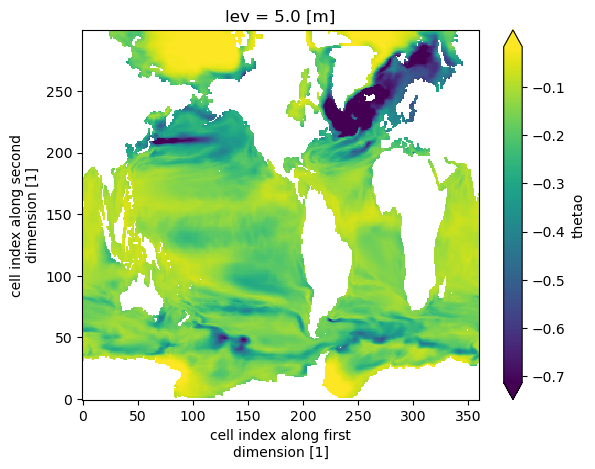

In [23]:
%%time
(chunked_for_time_member.thetao.isel(lev=0).mean('time').min('member') - chunked_for_time_member.thetao.isel(lev=0).mean('time').max('member')).plot(robust=True)

# chunk for 3D space & member

In [ ]:
chunked_for_time_member = xr.open_zarr(file_path+'ACCESS-ESM1.5-historical-thetao-chunk4time4member.zarr',consolidated=True)

In [ ]:
chunked_for_time_member_rc = chunked_for_time_member.chunk({'time':1,'lev':-1,'member':-1,'i':-1,'j':-1})
chunked_for_time_member_rc

In [ ]:
remove_zarr_encoding(chunked_for_time_member_rc)

In [ ]:
%%time
logging.info('chunk4xyz4member job started ')
chunked_for_time_member_rc.to_zarr(file_path+'ACCESS-ESM1.5-historical-thetao-chunk4xyz4member.zarr',consolidated=True)
logging.info('chunk4xyz4member job done ')

In [30]:
chunked_for_xyz_member = xr.open_zarr(file_path+'ACCESS-ESM1.5-historical-thetao-chunk4xyz4member.zarr',consolidated=True)

In [31]:
chunked_for_xyz_member

<xarray.Dataset>
Dimensions:  (i: 360, j: 300, lev: 50, member: 40, time: 1980)
Coordinates:
  * i        (i) int32 0 1 2 3 4 5 6 7 8 ... 351 352 353 354 355 356 357 358 359
  * j        (j) int32 0 1 2 3 4 5 6 7 8 ... 291 292 293 294 295 296 297 298 299
  * lev      (lev) float64 5.0 15.0 25.0 35.0 ... 5.166e+03 5.499e+03 5.831e+03
  * time     (time) datetime64[ns] 1850-01-16T12:00:00 ... 2014-12-16T12:00:00
Dimensions without coordinates: member
Data variables:
    thetao   (member, time, lev, j, i) float32 dask.array<chunksize=(40, 1, 50, 300, 360), meta=np.ndarray>

# THE END

In [ ]:
loaded_member1_40_rc = loaded_member1_40.chunk({'i':-1,'j':-1,'lev':50,'time':24,'member':1})
loaded_member1_40_rc

In [ ]:
remove_zarr_encoding(loaded_member1_40_rc)

In [ ]:
%%time
loaded_member1_40_rc.to_zarr(file_path+'r1-40.ACCESS-ESM1.5-historical-o2-chunk4xyz.zarr',consolidated=True)

In [ ]:
chuned_xyz = xr.open_zarr(file_path+'r1-40.ACCESS-ESM1.5-historical-o2-chunk4xyz.zarr',consolidated=True)

In [ ]:
chuned_xyz

In [ ]:
chuned_xyz.o2.mean(dim=['i','j','lev']).plot.line(x="time")

# can we chunk for lev & time?

In [ ]:
chunked_for_time_rc = chunked_for_time.chunk({'time':-1,'lev':-1,'member':1,'i':36,'j':30})
chunked_for_time_rc

In [ ]:
remove_zarr_encoding(chunked_for_time_rc)

In [ ]:
%%time
chunked_for_time_rc.to_zarr(file_path+'r1-40.ACCESS-ESM1.5-historical-o2-chunk4time4z.zarr',consolidated=True)

In [ ]:
chunked_time_z = xr.open_zarr(file_path+'r1-40.ACCESS-ESM1.5-historical-o2-chunktime4z.zarr',consolidated=True)

In [ ]:
! rm -rf /scratch/xv83/tm4888/tmp_rechunker/*.zarr # clean up any existing temporary data

In [ ]:
from rechunker import rechunk
target_chunks = {
    "o2": {'member':3,'time':12,'i':360,'j':300,'lev':25},
    "time": None,  # don't rechunk this array
    "i":None,
    "j":None,
    "lev":None,
    "latitude":None,
    "longitude":None
}
max_mem = "2000MB"

target_store = "/scratch/xv83/tm4888/tmp_rechunker/group_rechunked.zarr"
temp_store = "/scratch/xv83/tm4888/tmp_rechunker/group_rechunked-tmp.zarr"
source_group = DS_out

group_plan = rechunk(
    source_group, target_chunks, max_mem, target_store, temp_store=temp_store)
group_plan

In [ ]:
%%time
group_plan.execute()

# Can we open and use this zarr collection?

In [ ]:
data = xr.open_zarr('/scratch/xv83/tm4888/tmp_rechunker/group_rechunked.zarr',consolidated=True)

# can we write to large `zarr` collection?

In [ ]:
write_path = '/scratch/xv83/tm4888/zarr_collections/ACCESS_ESM1.5/'

In [ ]:
DS_out = DA_concat_rc.to_dataset()
DS_out

# remove encoding

In [ ]:
for var in DS_out:
    DS_out.encoding = {}

for coord in DS_out.coords:
    DS_out.encoding = {}

In [ ]:
%%time
DS_out.to_zarr(write_path + 'DS_out.zarr',consolidated=True)

# load back in 

In [ ]:
reloaded_data = xr.open_zarr(write_path + 'DS_out.zarr',consolidated=True)

In [ ]:
o2_historical_data

# remove encoding

In [ ]:
for var in o2_historical_data:
    o2_historical_data[var].encoding = {}

for coord in o2_historical_data.coords:
    o2_historical_data[coord].encoding = {}

In [ ]:
o2_historical_surface = o2_historical_data.isel(lev=0)

In [ ]:
o2_historical_surface

In [ ]:
o2_historical_surface_rc = o2_historical_surface.chunk({'member':-1,'time':-1,'i':36,'j':30})

In [ ]:
o2_historical_surface_rc

In [ ]:
%%time
o2_historical_surface_rc.to_zarr(write_path + 'ACCESS_ESM1.5_o2_40_member_surface_chunk4member4time.zarr',consolidated=True)

In [ ]:
data = xr.open_zarr(write_path + 'ACCESS_ESM1.5_o2_40_member_surface_chunk4member4time.zarr',consolidated=True)

In [ ]:
data

In [ ]:
result = (data.o2.max(dim = ['member','time']) - data.o2.mean(dim = ['member','time'])).compute()

In [ ]:
result.plot(robust=True)

In [ ]:
o2_emean = o2_historical_data.mean('member')

In [ ]:
o2_emean

In [ ]:
%%time
o2_emean.to_zarr(write_path + 'ACCESS_ESM1.5_o2_member_mean.zarr',consolidated=True)

# rechunk over member for some box

In [ ]:
box_data = DS_o2_monthly_hist.o2.isel({"lev":10}).sel(i=slice(60,150)).sel(j=slice(60,150))

In [ ]:
box_data

In [ ]:
box_data_rc = box_data.chunk({'member':-1,'time':200})

In [ ]:
box_data_rc

In [ ]:
%%time
box_data_rc.to_netcdf('/scratch/xv83/tm4888/PAC-TUNA/box_data_rc.nc')

In [ ]:
%%time
e_mean = box_data.mean(dim="member").compute()

# ----------------------------

In [ ]:
box_data_rc = xr.open_mfdataset('/scratch/xv83/tm4888/PAC-TUNA/box_data_rc.nc',parallel=True)

In [ ]:
box_data_rc

In [ ]:
%%time
emean = box_data_rc.mean('member').compute()

# Load the production ACCESS-NRI catalogue

In [ ]:
import intake

cat = intake.cat.access_nri

esm_ds = cat["cmip6_fs38"]

esm_ds.esmcat.aggregation_control.groupby_attrs = [
    attrs for attrs in esm_ds.esmcat.aggregation_control.groupby_attrs
    if attrs != "version"
]

esm_ds_filtered = esm_ds.search(
    source_id="ACCESS-ESM1-5", 
    experiment_id="ssp370", 
    table_id="Omon", 
    variable_id="o2", 
    file_type="l"
)

In [ ]:
esm_ds_filtered.unique()['version']

In [ ]:
esm_ds_filtered

In [ ]:
DS_dict = esm_ds_filtered.to_dataset_dict(progressbar=False)
DS_dict

In [ ]:
DS_dict

In [ ]:
DS_o2_monthly_ssp370 = xr.concat(
    DS_dict.values(), 
    dim="member"
)

In [ ]:
DS_o2_monthly_ssp370

In [ ]:
result = DS_o2_monthly_ssp370.o2.isel(lev=20).mean(dim=['i','j'])

In [ ]:
result

In [ ]:
result.plot()

In [ ]:
ds

In [ ]:
esm_ds_filtered['l.CMIP.CSIRO.ACCESS-ESM1-5.ssp585.r9i1p1f1.mon.ocnBgchem.Omon.o2.gn'].df

In [ ]:
esm_ds_filtered.keys()

In [ ]:
esm_ds_filtered['l.CMIP.CSIRO.ACCESS-ESM1-5.ssp585.r40i1p1f1.mon.ocnBgchem.Omon.o2.gn'].df

In [ ]:
import intake

nri_cat = intake.cat.access_nri

In [ ]:
cmip6_fs38_cat = nri_cat['cmip6_fs38']
cmip6_fs38_cat

In [ ]:
ScenarioMIP6_fs38_cat = cmip6_fs38_cat.search(path='/g/data/fs38/publications/CMIP6/ScenarioMIP/*')

In [ ]:
ScenarioMIP6_fs38_cat.unique()['realm']

In [ ]:
ScenarioMIP6_fs38_oceanBGC_cat = ScenarioMIP6_fs38_cat.search(realm=['ocnBgchem'])

In [ ]:
ScenarioMIP6_fs38_oceanBGC_cat

In [ ]:
ScenarioMIP6_fs38_o2_cat = ScenarioMIP6_fs38_oceanBGC_cat.search(variable_id='o2')
ScenarioMIP6_fs38_o2_cat

In [ ]:
ScenarioMIP6_fs38_o2_cat.unique()['frequency']

In [ ]:
ScenarioMIP6_fs38_monthly_o2_cat = ScenarioMIP6_fs38_o2_cat.search(frequency='mon')
ScenarioMIP6_fs38_monthly_o2_cat

In [ ]:
ScenarioMIP6_fs38_monthly_o2_cat.unique()['experiment_id']

In [ ]:
ScenarioMIP6_fs38_ssp585_monthly_o2_cat = ScenarioMIP6_fs38_monthly_o2_cat.search(experiment_id = 'ssp585')
ScenarioMIP6_fs38_ssp585_monthly_o2_cat

In [ ]:
ScenarioMIP6_fs38_ssp585_monthly_o2_cat.unique()['version']

In [ ]:
ScenarioMIP6_fs38_ssp585_monthly_o2_40e_cat = ScenarioMIP6_fs38_ssp585_monthly_o2_cat.search(version=['v20210831','v20210318'])
ScenarioMIP6_fs38_ssp585_monthly_o2_40e_cat

In [ ]:
ScenarioMIP6_fs38_ssp585_monthly_o2_d20210831_cat = ScenarioMIP6_fs38_ssp585_monthly_o2_cat.search(version='d20210831')
ScenarioMIP6_fs38_ssp585_monthly_o2_d20210831_cat

In [ ]:
ScenarioMIP6_fs38_ssp585_monthly_o2_v20210831_cat.df.head()

In [ ]:
ScenarioMIP6_fs38_ssp585_monthly_o2_v20210831_cat.unique()['time_range']

In [ ]:
ScenarioMIP6_fs38_ssp585_monthly_o2_v20210831_cat.unique()['member_id']

In [ ]:
ScenarioMIP6_fs38_ssp585_monthly_o2_v20210831_r40i1p1f1_cat = ScenarioMIP6_fs38_ssp585_monthly_o2_v20210831_cat.search(member_id = 'r40i1p1f1')
ScenarioMIP6_fs38_ssp585_monthly_o2_v20210831_r40i1p1f1_cat

In [ ]:
dataset = ScenarioMIP6_fs38_ssp585_monthly_o2_v20210831_r40i1p1f1_cat.to_dask(progressbar=False)

In [ ]:
dataset

In [ ]:
dataset['o2'].encoding

In [ ]:
o2_chunked_for_time = dataset.o2.chunk({'time':-1,'lev':25,'i':50,'j':18})

In [ ]:
o2_chunked_for_time

In [ ]:
o2_200m = o2_chunked_for_time.isel(lev=slice(0,21))

In [ ]:
o2_200m

In [ ]:
write_path = '/scratch/xv83/tm4888/zarr_collections/'

In [ ]:
o2_200m.to_zarr(write_path + 'ACCESS_ESM1.5_o2_200m_r40i1p1f1.zarr',consolidated=True)

# read back in

In [ ]:
o2 = xr.open_zarr(write_path + 'ACCESS_ESM1.5_o2_200m_r40i1p1f1.zarr',consolidated=True)

In [ ]:
o2

In [ ]:
o2_clim = o2.groupby('time.month').mean()

In [ ]:
o2_clim

In [ ]:
%%time
o2_clim = o2_clim.compute()

In [ ]:
o2_anom = o2.groupby('time.month') - o2_clim

In [ ]:
o2_anom

In [ ]:
PLOT_DATA = o2_anom.o2.isel(time=1031,lev=20)

In [ ]:
%%time
PLOT_DATA = PLOT_DATA.compute()

In [ ]:
import cartopy.crs as ccrs
plt.figure(figsize=(14, 6))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.set_global()
PLOT_DATA.plot.pcolormesh(
    ax=ax, transform=ccrs.PlateCarree(), x="longitude", y="latitude"
)
ax.coastlines()
plt.title('o2 December anomaly year 2100\n 205m \n ACCESS_ESM1.5_o2_200m_r40i1p1f1')

In [ ]:
diff = dataset.o2.isel(time=0) - dataset.o2.isel(time=1031)

In [ ]:
diff

In [ ]:
yearly_mean = dataset

In [ ]:
mean_depth_diff = diff.mean('lev')
mean_depth_diff

In [ ]:
import cartopy.crs as ccrs
plt.figure(figsize=(14, 6))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.set_global()
mean_depth_diff.plot.pcolormesh(
    ax=ax, transform=ccrs.PlateCarree(), x="longitude", y="latitude"
)
ax.coastlines()
plt.title('depth mean O2 // 

In [ ]:
mean_depth_diff.plot(x=mean_depth_diff['longitude'],y=mean_depth_diff['latitude'])

In [ ]:
source_dict = ScenarioMIP6_fs38_ssp585_monthly_o2_v20210831_cat.to_source_dict()

In [ ]:
dataset_dict

In [ ]:
dataset_dict.keys()

In [ ]:
ESM15_o2_cat = cmip6_fs38_cat.search(path='/g/data/fs38/publications/CMIP6/CMIP/CSIRO/ACCESS-ESM1-5/*',variable_id = 'o2')

In [ ]:
ESM15_o2_cat

In [ ]:
ESM15_o2_cat.unique()['experiment_id']

In [ ]:
ESM15_o2_cat.unique()['frequency']

In [ ]:
ESM15_monthly_o2_cat = ESM15_o2_cat.search(frequency='mon')

In [ ]:
ESM15_monthly_o2_cat

In [ ]:
ESM15_monthly_o2_cat.unique()['experiment_id']

# Extension BGC run `01deg_jra55v140_iaf_cycle4_jra55v150_extension`

In [ ]:
BGC_extension_cat = nri_cat['01deg_jra55v140_iaf_cycle4_jra55v150_extension']
BGC_extension_cat

# Can we build monthly (or daily) datasets for TEMP and O2 ?

In [ ]:
# show nri cat metadata
nri_cat.metadata

In [ ]:
BGC_extension_cat.search(variable='o2').keys()

In [ ]:
BGC_extension_cat.search(file_id='oceanbgc_3d_o2_1_monthly_mean_4_sigfig_ym_XXXX_XX')

In [ ]:
BGC_extension_cat.df.head()

In [ ]:
monthly_o2 = BGC_extension_cat.search(file_id='oceanbgc_3d_o2_1_monthly_mean_4_sigfig_ym_XXXX_XX')

In [ ]:
monthly_o2_data = monthly_o2.to_dask(xarray_open_kwargs=dict(chunks={'time':100,'yt_ocean':540,'xt_ocean':720}))

In [ ]:
monthly_o2_data

In [ ]:
monthly_o2_data.o2.isel({'time':0,'st_ocean':10}).plot()

In [ ]:
daily_o2_extension_search = BGC_extension_cat.search(realm='ocean',frequency='1day',variable=['o2'])

In [ ]:
daily_o2_extension_search

In [ ]:
daily_extension_search = BGC_extension_cat.search(realm='ocean',frequency='1day')

In [ ]:
daily_extension_search

In [ ]:
daily_extension_search.unique()['variable']

In [ ]:
temp_o2_extension_data = temp_o2_extension_search.to_dask(xarray_open_kwargs=dict(chunks={'time':100,'yt_ocean':540,'xt_ocean':720}))

In [ ]:
temp_o2_extension_data

### MLD test run - COSIMA

In [ ]:
mld_extension_search = BGC_extension_cat.search(realm='ocean',frequency='1day',variable='mld')
mld_extension_search

In [ ]:
mld_extension_data = mld_extension_search.to_dask(xarray_open_kwargs=dict(chunks={'time':100,'yt_ocean':540,'xt_ocean':720}))

In [ ]:
mld_extension_data

# Base BGC run `01deg_jra55v140_iaf_cycle4`

In [ ]:
BGC_cat = cat['01deg_jra55v140_iaf_cycle4']
BGC_cat

In [ ]:
mld_search = BGC_cat.search(realm='ocean',frequency='1day',variable='mld')
mld_search

In [ ]:
mld_search.df

In [ ]:
mld_data = mld_search.to_dask(xarray_open_kwargs=dict(chunks={'time':100,'yt_ocean':540,'xt_ocean':720}))

In [ ]:
mld_data

# What do these individual DS's look like?

In [ ]:
mld_data

In [ ]:
mld_extension_data

# Concat base and extension MLD data

In [ ]:
%%time
mld_DS = xr.concat([mld_data,mld_extension_data],dim='time')

In [ ]:
mld_DS

# can we write this to `zarr` on scratch?

In [ ]:
rechunked_mld_DS = mld_DS.chunk({'time':100})

In [ ]:
rechunked_mld_DS

In [ ]:
write_path = '/scratch/xv83/tm4888/zarr_collections/'

In [ ]:
%%time
rechunked_mld_DS.to_zarr(write_path+'daily.mld.concat.chunk.100-540-720.zarr', consolidated = True)

In [ ]:
test_read = xr.open_zarr(write_path+'daily.mld.concat.chunk.100-540-720.zarr', consolidated = True)

In [ ]:
test_read

In [ ]:
point = test_read.mld.max(dim=['xt_ocean','yt_ocean'])

In [ ]:
point

In [ ]:
point.plot()

In [ ]:
client.close()